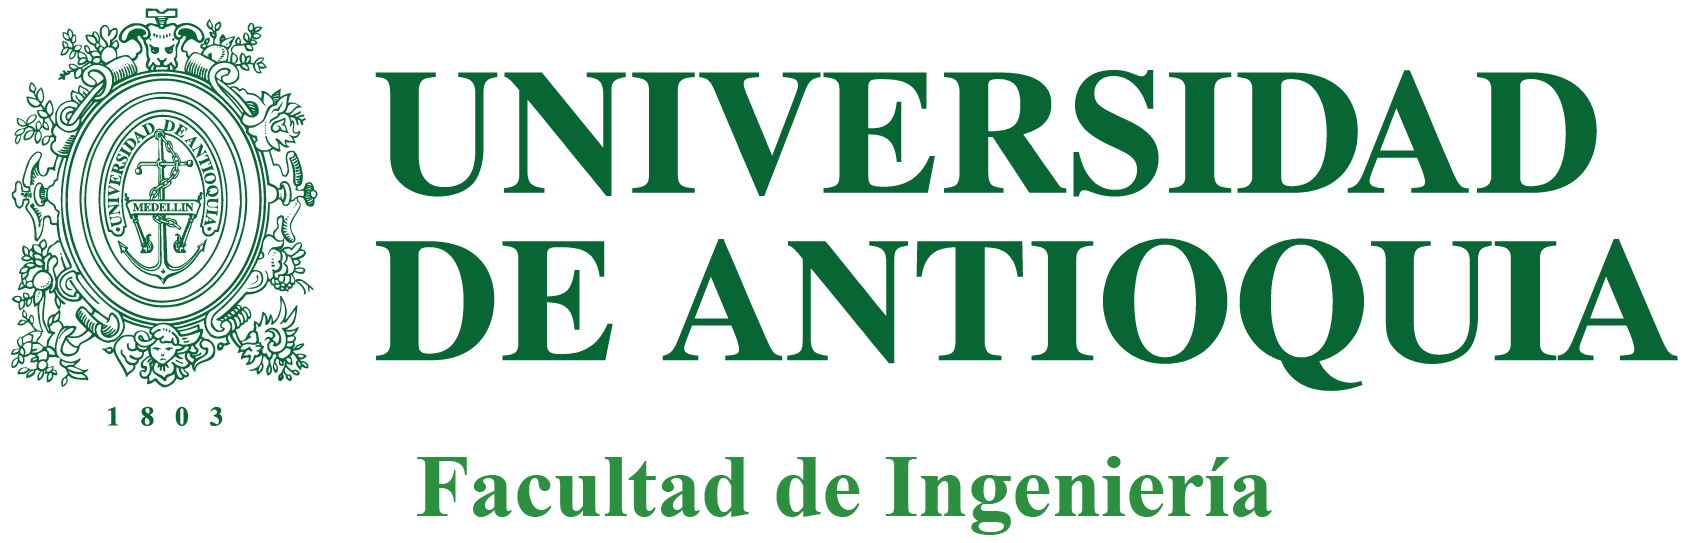
---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

- Santiago Torres Velásquez
- Santiago Narváez Toro

In [ ]:
# Librerías para la ejecución del notebook

import os,random
import numpy as np
import pickle, sys
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.models as models
from tensorflow.keras.layers import Conv2D

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.regularizers import *
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import GaussianNoise
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

%matplotlib inline

In [ ]:
# Descarga de los datos
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:11<00:00, 58.1MB/s]


In [ ]:
# Cargar el dataset
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

# Calculate modulations and signal-to-noise ratios contained in dataset.
# Calcular las modulationes y las relaciones señal a ruido contenidas en los datos.
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

print('Modulaciones presentes en el dataset: {}'.format(mods))
print('Relaciones señal a ruido en el dataset: {}'.format(snrs))

Modulaciones presentes en el dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Relaciones señal a ruido en el dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [ ]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ La primera dimensión representa las 1,000 ventanas muestreadas (cada ventana tiene las 128 muestras de I y Q).
+ La segunda dimensión representa los dos componentes (I y Q) de la señal de radiofrecuencia.
+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, por lo que 1 $\mu$s por índice).

Este "shape" puede realizarse para cualquier dupla de valores ('Tipo de modulación', 'relación señal a ruido')


In [ ]:
# Función que permite reconstruir la señal en el dominio del tiempo
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

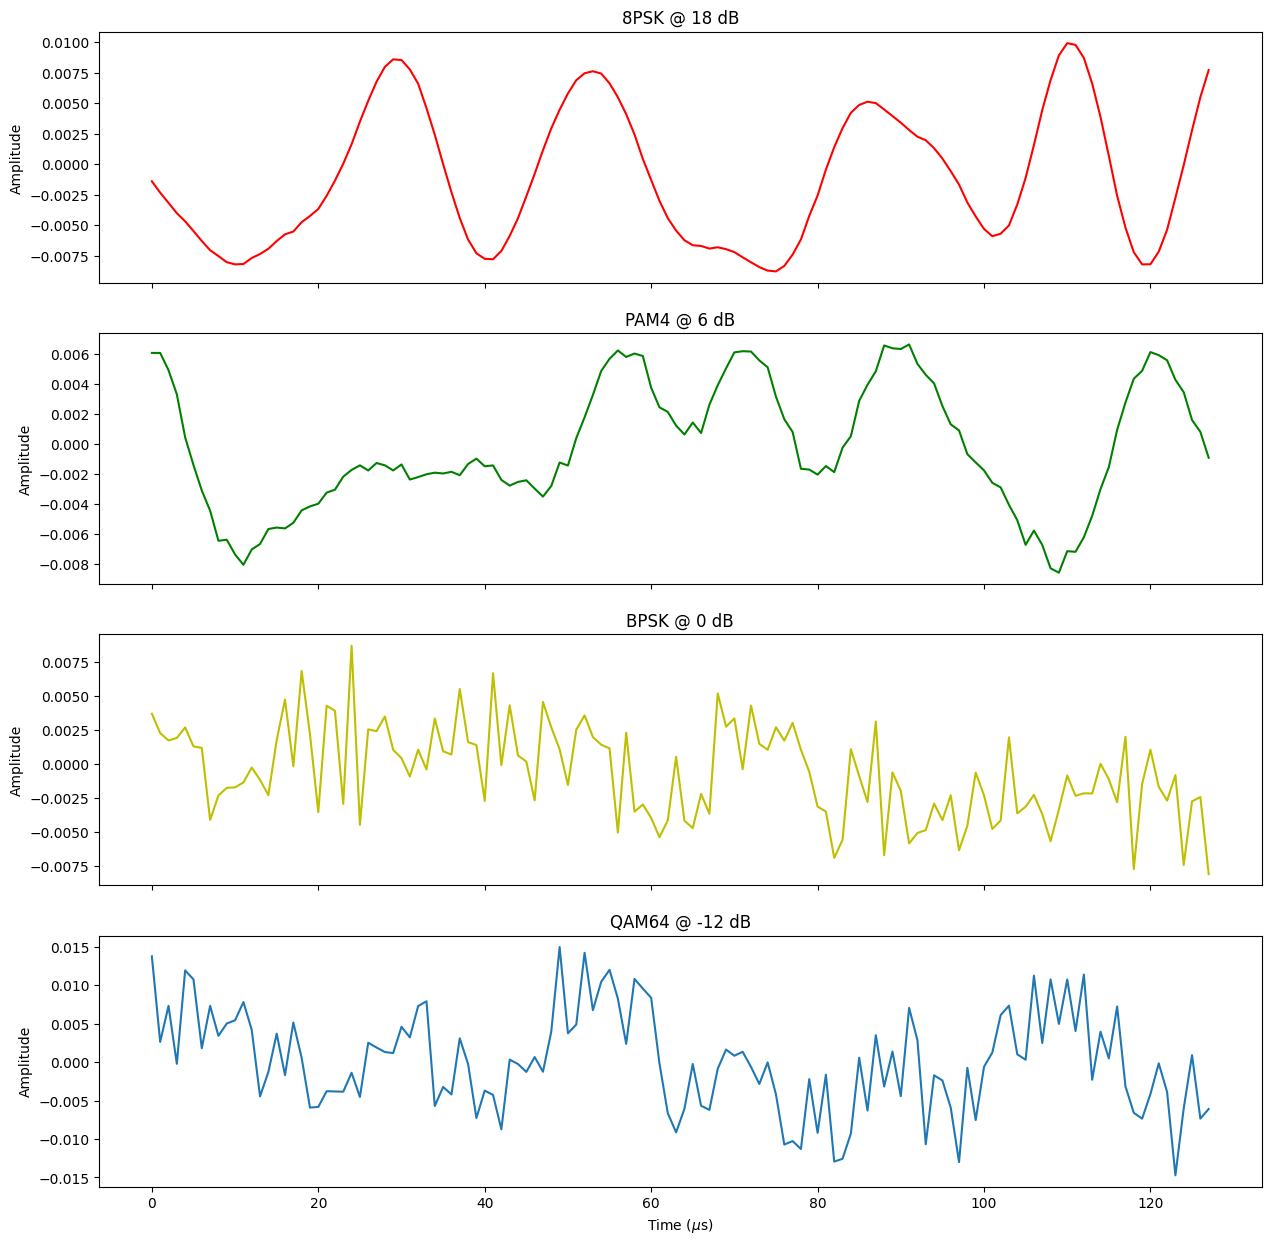

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')
plt.ylabel('Amplitude');

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')
plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')
plt.ylabel('Amplitude');

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')
plt.ylabel('Amplitude');

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

Ahora necesitamos concatenar todas las modulaciones, relaciones señal-ruido (SNR), muestras, canales y puntos temporales en una única matriz grande para pasarla a nuestra red neuronal.

Habrá 220000 muestras. Cada muestra es de tamaño 2 x 128. Los 2 corresponden a los canales I y Q. Los 128 son las 128 muestras temporales de la forma de onda (muestreadas a 1 MHz).

El tamaño de la matriz corresponde a la cantidad de modulaciones y SNR presentes en los datos:

+ Modulaciones = 11
+ SNR's = 20
+ Muestras por cada pareja de datos = 1000

Finalmente el total de muestras en la matriz será de $11*20*1000 = 220000$ muestras.

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Verificar la dimensionalidad de la matriz.
np.shape(X)

(220000, 2, 128)

## Añadir ruido al conjunto de datos

La idea es agregar 2 canales de ruido gaussiano aleatorio para brindarle a la red la opción de elegir si no puede decidir entre las verdaderas modulaciones. Básicamente, esto es una clasificación de "I don't know".

In [ ]:
numNoiseSamples = 20000 # 20000 muestras de ruido gaussiano
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Añadir ruido al final de los datos

La tarea inicial consiste en llevar a cabo una codificación One Hot de los nombres de las modulaciones, con el propósito de representar esta información de manera comprensible para la computadora mediante valores numéricos.

In [ ]:
lbl = np.array(lbl) # Convertir de lista a numpy array

y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [ ]:
# Se verifica el funcionamiento de la codificación
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Dividir los datos en entrenamiento y test.


In [ ]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Ahora obtenemos una lista de índices aleatorios para muestrear el conjunto de entrenamiento
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# El conjunto de prueba se forma con los demás índices.
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Dividir los datos según los índices
X_train = X[train_idx]

X_train = X_train[10000:]
X_test =  X[test_idx]
X_validation = X_train[:10000]

Y_train = y_encoded[train_idx]

Y_train = Y_train[10000:]
Y_test = y_encoded[test_idx]
Y_validation = Y_train[:10000]

print('Dimensionalidad de los datos de entrenamiento {}'.format(np.shape(X_train)))
print('Dimensionalidad de los datos de test {}'.format(np.shape(X_test)))
print('Dimensionalidad de los datos de validación {}'.format(np.shape(X_validation)))

Dimensionalidad de los datos de entrenamiento (158000, 2, 128)
Dimensionalidad de los datos de test (72000, 2, 128)
Dimensionalidad de los datos de validación (10000, 2, 128)


In [ ]:
# Se aprecia el ruido agregado y la dimensionalidad de los datos de entrenamiento
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods
print(classes)

(158000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


# Construcción del modelo NN

En este punto lo que se hará es codificar 2 arquitecturas CNN para evaluar el reconocimiento de modulación utilizando enfoques de aprendizaje profundo

In [ ]:
dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
w, h = 2, 128

# Reshape [N,2,128] to [N,2,128,1] on input
X_train_reshaped = X_train.reshape(X_train.shape[0], w, h, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], w, h, 1)
X_validation_reshaped = X_validation.reshape(X_validation.shape[0], w, h, 1)

model.add(Reshape((w,h,1), input_shape=(w,h)))

# Pass through 3 2DConv/ReLu layers
model.add(Convolution2D(filters=32, kernel_size=(1,6), padding='same', activation='relu', input_shape=(w,h,1)))
model.add(Convolution2D(filters=64, kernel_size=(1,6), padding='same', activation='relu'))
model.add(Convolution2D(filters=128, kernel_size=(1,6), padding='same', activation='relu'))

# Flatten layer
model.add(Flatten())

# 2 Dense layers (ReLu and Softmax)
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))

model.add(Dense(12, activation='softmax'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 32)        224       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 128, 64)        12352     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 128)       49280     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
# Compilar el modelo con categorical_crossentropy
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Entrenamiento del modelo

Para el entrenamiento del modelo, se hace uso de `ModelCheckpoint` y `EarlyStopping` para supervisar el entrenamiento y evitar el sobreajuste.

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.70376, saving model to ./PESOS_TSIII.wts.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


155/155 - 26s - loss: 2.0056 - accuracy: 0.2742 - val_loss: 1.7038 - val_accuracy: 0.3641 - 26s/epoch - 170ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.70376
155/155 - 13s - loss: 1.7694 - accuracy: 0.3516 - val_loss: 2.0660 - val_accuracy: 0.2608 - 13s/epoch - 85ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.70376 to 1.50765, saving model to ./PESOS_TSIII.wts.h5
155/155 - 13s - loss: 1.7699 - accuracy: 0.3499 - val_loss: 1.5076 - val_accuracy: 0.4468 - 13s/epoch - 82ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.50765 to 1.39051, saving model to ./PESOS_TSIII.wts.h5
155/155 - 14s - loss: 1.5167 - accuracy: 0.4312 - val_loss: 1.3905 - val_accuracy: 0.4787 - 14s/epoch - 89ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.39051 to 1.35633, saving model to ./PESOS_TSIII.wts.h5
155/155 - 13s - loss: 1.4494 - accuracy: 0.4567 - val_loss: 1.3563 - val_accuracy: 0.4946 - 13s/epoch - 84ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 1.35633
155

El modelo muestra una mejora inicial en la pérdida en el conjunto de validación hasta la epoch 3, indicando una capacidad inicial para generalizar a datos no vistos. Sin embargo, a partir de la epoch 3, la pérdida en validación no mejora de manera consistente y muestra fluctuaciones. Se observa cierto grado de sobreajuste, ya que la pérdida en entrenamiento disminuye constantemente, pero la pérdida en validación deja de mejorar después de un punto, indicando una falta de generalización. La precisión en validación alcanza su punto máximo alrededor de la epoch 15, pero luego muestra pequeñas oscilaciones. El uso de callbacks como ModelCheckpoint y EarlyStopping se refleja en el guardado de los mejores pesos y la interrupción temprana del entrenamiento después de 41 epoch debido a la falta de mejora significativa en la pérdida de validación.

# Evaluate and Plot Model Performance

In [ ]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

71/71 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      5957
           1       0.55      0.70      0.61      5852
           2       0.26      0.93      0.41      5932
           3       0.82      0.58      0.68      6051
           4       0.79      0.61      0.69      5963
           5       0.77      0.64      0.70      6022
           6       1.00      1.00      1.00      6125
           7       0.90      0.64      0.75      5991
           8       0.45      0.27      0.34      5906
           9       0.55      0.46      0.50      6029
          10       0.71      0.29      0.41      6072
          11       0.76      0.22      0.34      6100

    accuracy                           0.57     72000
   macro avg       0.67      0.57      0.58     72000
weighted avg       0.67      0.57      0.58     72000



El modelo presenta resultados variados en la clasificación por clases, evidenciando fortalezas y debilidades específicas en la identificación de diferentes categorías. La precisión global del modelo es del 57%, indicando que, en promedio, el 57% de las predicciones son correctas, con un recall global del mismo valor, lo que sugiere que aproximadamente el 57% de las instancias positivas son correctamente identificadas. Se observa una diferencia notoria entre las clases, algunas con buenos resultados y otras con desempeño limitado. El F1-score global es del 58%, y las métricas ponderadas indican un rendimiento promedio superior, pero aún hay espacio para mejoras, especialmente en la gestión de clases con bajos valores de precision o recall.

## Loss curves

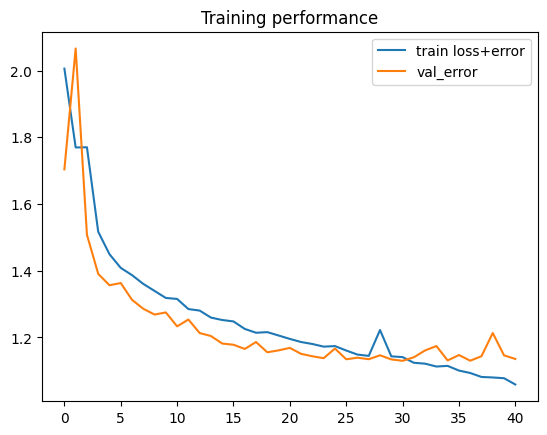

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

Una forma de visualizar el desempeño del modelo es viendo esta gráfica de la curva de pérdida, tanto el conjunto de entrenamiento como el de validación. Podemos observar que la pérdida en el conjunto de validación tiene un comportamiento similar que la pérdida en el conjunto de entrnamiento. En general esta se mantiene por debajo, excepto al principio y al final de la gráfica. Esto es debido a que al revisar los epoch, la pérdida de validación es mayor que la pérdida de entrenamiento. Esto mejora a medida que el modelo toma más información de los datos presentados.

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 2s 23ms/step


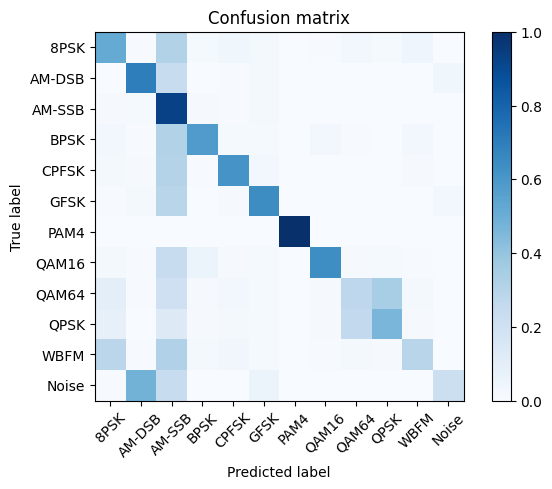

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

La matriz de confusión muestra la cantidad de predicciones correctas e incorrectas hechas por el modelo en cada clase. La matriz tiene dimensiones NxN, donde N es el número de clases en el problema de clasificación (modulaciones).

Los elementos diagonales representan las predicciones correctas para cada clase. Por ejemplo, el elemento en la posición (i, i) indica cuántas instancias de la clase i fueron correctamente clasificadas.

Los elementos fuera de la diagonal principal son errores. El elemento en la posición (i, j) indica cuántas instancias de la clase i fueron incorrectamente clasificadas como clase j.

La matriz de confusión proporciona una visión detallada del rendimiento del modelo, permitiendo observar que, las modulaciones que mejor se estimaron corresponden a AM-SSB y PAM4.

Pleaes evaluate the model in terms of $SNR$ and their accuracy for each modulation (below is a a sample code to assess your models)

112/112 [==============================] - 1s 3ms/step
Overall Accuracy for SNR -20: 0.16764459346186086
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.1758515646635281
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.17436458048647172
114/114 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -14: 0.1793598233995585
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -12: 0.20810514786418402
116/116 [==============================] - 1s 4ms/step
Overall Accuracy for SNR -10: 0.26695604991861094
111/111 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -8: 0.39609838846480067
112/112 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -6: 0.5407220822837951
112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -4: 0.6475020932179738
114/114 [==============================] - 0s 3ms/step
Overall

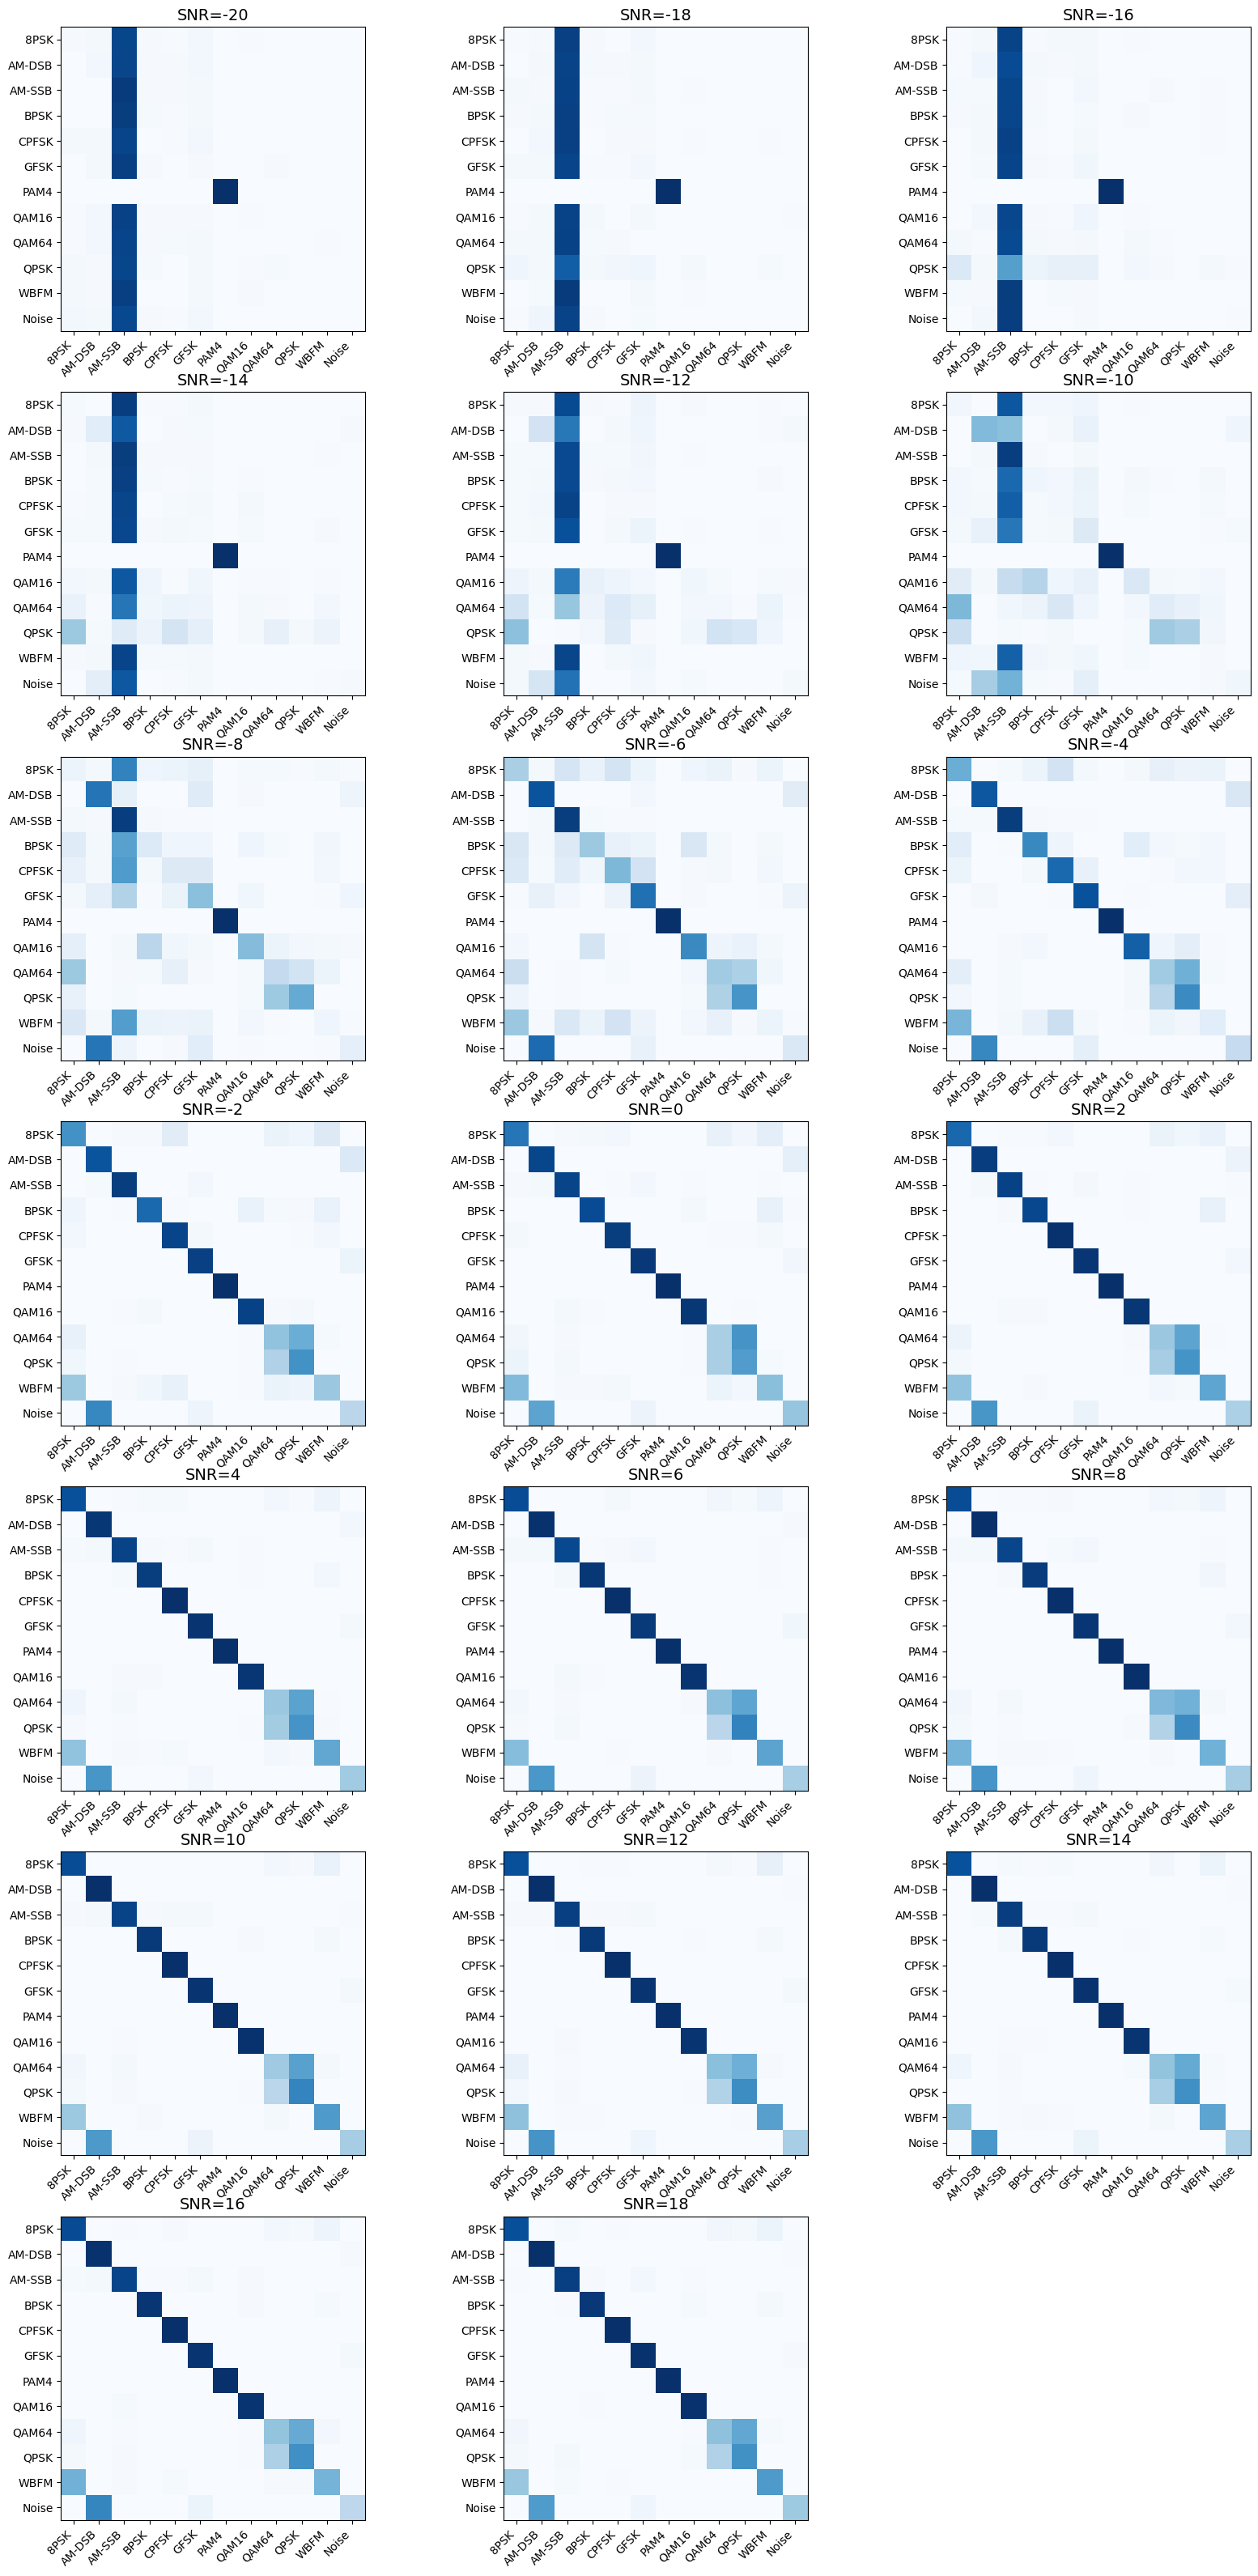

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir el número de filas y columnas
num_filas = 7
num_columnas = 3
acc = {}

# Ajustar el tamaño de los subgráficos
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 40))

# Iterar sobre las relaciones SNR y crear un subplot para cada una
for i, snr in enumerate(snrs):
    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    aux_vector = np.array(list(test_SNRs))
    test_X_i = X_test[np.where(aux_vector == snr)]
    test_Y_i = Y_test[np.where(aux_vector == snr)]

    # Check if there are data samples for the current SNR
    if len(test_X_i) == 0:
        print("No data samples available for SNR: {}".format(snr))
        continue

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for j in range(0, test_X_i.shape[0]):
        true_label = list(test_Y_i[j, :]).index(1)
        predicted_label = int(np.argmax(test_Y_i_hat[j, :]))
        conf[true_label, predicted_label] += 1

    for j in range(0, len(classes)):
        confnorm[j, :] = conf[j, :] / np.sum(conf[j, :])

    # Obtener la posición del subplot en la matriz de subgráficos
    fila_actual = i // num_columnas
    columna_actual = i % num_columnas

    # Crear un subplot y mostrar la matriz de confusión en ese subplot
    im = axs[fila_actual, columna_actual].imshow(confnorm, interpolation='nearest', cmap=plt.cm.Blues)
    axs[fila_actual, columna_actual].set_title("SNR={}".format(snr), fontsize=14)
    axs[fila_actual, columna_actual].set_xticks(np.arange(len(classes)))
    axs[fila_actual, columna_actual].set_yticks(np.arange(len(classes)))
    axs[fila_actual, columna_actual].set_xticklabels(classes, fontsize=10, rotation=45, ha="right")  # Añadir rotation y ha
    axs[fila_actual, columna_actual].set_yticklabels(classes, fontsize=10)

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

# Eliminar el último subplot
fig.delaxes(axs[-1, -1])

# Mostrar los subgráficos
plt.show()

En los gráficos previos, se ha generado la matriz de confusión y calculado la métrica de precisión para las diversas modulaciones, abarcando todas las Relaciones Señal-Ruido (SNR).

Cuando la SNR es muy baja (negativa), las predicciones tienden a ser imprecisas, ya que se encuentran afectadas por niveles elevados de ruido. En contraste, para SNRs elevadas (positivas), se observa una mejora significativa en las predicciones debido a la reducción de la interferencia por ruido. Este comportamiento sugiere una relación inversa entre la precisión del modelo y los niveles de ruido, siendo más robusto en condiciones de señal más fuerte y menos fiable en entornos con señales más débiles.

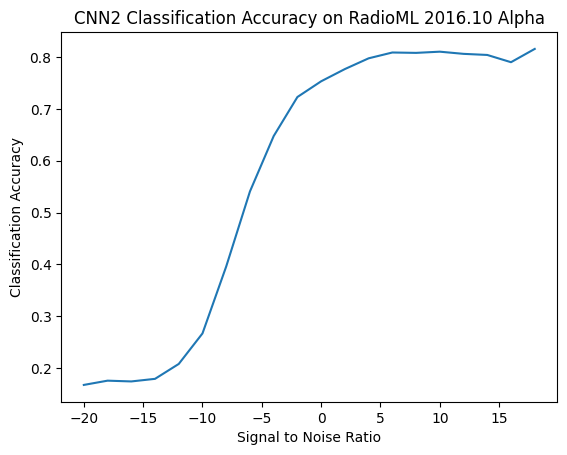

In [ ]:
accuracy_values = [acc[snr] for snr in snrs]

plt.plot(snrs, accuracy_values)

plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
plt.show()

Esta representación gráfica posibilita la observación del rendimiento de la precisión en relación con las veinte Relaciones Señal-Ruido (SNRs) presentes en el conjunto de datos. De acuerdo con lo señalado previamente, se ratifica que la exactitud (accuracy) experimenta una mejora conforme aumenta el valor de la SNR.

## Conclusiones

- La implementación de redes neuronales se destaca por su capacidad para aprender patrones complejos a partir de datos, permitiendo ajustar sus parámetros internos y mejorar el rendimiento a medida que se le suministra más información. Esta versatilidad posibilita su aplicación en diversas tareas, desde el reconocimiento de patrones hasta el procesamiento del lenguaje natural.

- La introducción de capas de activación en el modelo aporta no linealidad, permitiendo a la red aprender y representar relaciones complejas en los datos. La variación de funciones de activación y la manipulación de capas contribuyen significativamente a adaptar el modelo para obtener mejores resultados.

- El aumento del tamaño del kernel en una red neuronal convolucional resulta en la captura de patrones más complejos en los datos, mejorando la precisión al permitir que el modelo aprenda patrones más extensos y significativos.

- La elección del valor de paso en la capa convolucional es crucial, ya que un paso grande puede reducir la resolución espacial y, por ende, provocar pérdida de información relevante. Ajustar este parámetro puede influir en la convergencia, el tiempo de entrenamiento y la ubicación de mínimos locales, destacando la importancia de monitorear estos efectos durante el proceso.

- La matriz de confusión emerge como una herramienta esencial para entender cómo el modelo clasifica las diferentes clases, identificando áreas donde se producen confusiones. Analizar las celdas fuera de la diagonal principal proporciona información valiosa sobre las clases que el modelo tiende a confundir más frecuentemente.

- Dada la disparidad en el rendimiento entre clases, se sugiere explorar enfoques adicionales, como el ajuste del equilibrio de clase, la aplicación de técnicas de aumento de datos para clases subrepresentadas y la optimización de hiperparámetros específicos para mejorar la precisión y el recall en todas las clases.